In [1]:
%load_ext autoreload
%autoreload 2

# Introduction 

This notebook aims to do the following
1. Replicate (most) of the work done in the colab file
2. Integrate the blair model embedding as inputs
3. Use our input files (product and user) metadata instead of the hugging face ones 


# Imports

In [252]:
import pandas as pd
import torch
import random

from datasets import load_dataset
from utils.setup_graph import make_mapping, create_nodes, train_test_validation_split
from utils.setup_embeddings import instantiate_users, custom_BLaIR_text_embedding_model
from utils.graph_model import BaseGNNRecommender, GNNSAGERecommender
from utils.graph_helpers import train_model, plot_loss, final_evaluation
from utils.recomendations import recommend_products, pretty_print_recomendations, paper_evaluation

# Load dataset

Original data as obtained from the colab notebook  
Additional data is obtained from the `All_Beauty_cleaned data` folder. 

In [3]:
reviews_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", trust_remote_code=True)
product_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty", split="full", trust_remote_code=True)

review_df = reviews_dataset['full'].to_pandas()
product_df = product_dataset.to_pandas()

In [4]:
agg_user_df = pd.read_csv("data/user_metadata.csv")
new_product_df = pd.read_csv("data/product_metadata.csv")

In [5]:
review_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,[],B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",[],B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",[],B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True
3,1.0,Synthetic feeling,Felt synthetic,[],B09JS339BZ,B09JS339BZ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1643393630220,0,True
4,5.0,A+,Love it,[],B08BZ63GMJ,B08BZ63GMJ,AFQLNQNQYFWQZPJQZS6V3NZU4QBQ,1609322563534,0,True


In [6]:
product_df.sample(2)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
44774,All Beauty,Goddess Senegalese Twist Hair Crochet Braids C...,5.0,1,[],[],None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Liang Dian,[],"{""Brand"": ""Liang Dian"", ""Extension Length"": ""1...",B08F9FN41D,None,None,None
34162,All Beauty,Girzzur 4 Pieces Silky Durags Pack for Men Wav...,3.9,16,[],[],None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Girzzur,[],"{""Package Dimensions"": ""10.94 x 7.99 x 0.98 in...",B08NDGYJN3,None,None,None


In [7]:
agg_user_df.head()

,user_id,rating_mean,rating_count,helpful_vote_mean,helpful_vote_gte_1,verified_purchase_mean,last_active_in_days_min,last_active_in_days_max,word_count_mean,reviews
0,AE222BBOVZIF42YOOPNBXL4UUMYA,5.0,1,0.0,0,1.0,2739,2739,8.0,Five Stars Great product....excellent price fo...
1,AE222FP7YRNFCEQ2W3ZDIGMSYTLQ,5.0,1,0.0,0,1.0,185,185,6.0,Nice consistency and great smell [[VIDEOID:8b3...
2,AE222X475JC6ONXMIKZDFGQ7IAUA,5.0,1,2.0,1,1.0,2436,2436,4.0,Wow It tastes good
3,AE222Y4WTST6BUZ4J5Y2H6QMBITQ,4.0,1,1.0,1,1.0,3728,3728,34.0,Lensoclean Unit The cleaning unit does a good ...
4,AE2232TEZOEWQLAFEX2NA6VBGMYQ,5.0,1,0.0,0,1.0,1501,1501,7.0,Sus colores Son como en la foto


In [8]:
new_product_df.head()

,parent_asin,meta,reviews
0,0124784577,WOW Organics Apple Cider Vinegar Shampoo - 300 mL,Product delivers Makes my hair look healthy ||...
1,0692508988,The Listening Cards The Listening Cards are an...,Delightful and Profound This is a wonderful to...
2,069267599X,Inspirational Card Deck Nicole Piar created th...,Sigh I soo much wanted to Really love this dec...
3,0764490117,Kingdom Rock Starter Kit: Where Kids Stand Str...,Amazing VBS kit! We just completed our week of...
4,0816091846,"Sissy Spacek Collection - Raggedy Man, The Riv...","Wish she would'a done comedy, too! Spacek can ..."


In [9]:
print('review df len:\t\t', len(review_df))
print('product df len:\t\t', len(product_df))
print("agg user df len:\t", len(agg_user_df))
print("new product df len:\t", len(new_product_df))

review df len:		 701528
product df len:		 112590
agg user df len:	 631986
new product df len:	 89060


So we now want to transfor the dataset to the columns / how we want them to be 

**review_df**  
This is the original df used.  
We only need to know the user to product mapping (node to node) and the rating (edge weight) 

**product_df**  
I elect not to use it because the new product df might be a better source (cleaned i guess)   
kept some columns for the pretty print of recomendations 

**agg_user_df**  
I take the aggregated data as the start embeddings.   
self note / to do: a method to also create a blank user start embedding as seen in the colab  

**new product df**  
used as is given 

In [10]:
edge_list_df = review_df[["user_id", "parent_asin", "rating"]].copy()

In [11]:
user_node_content_df = agg_user_df.drop("reviews", axis = 1).copy()

In [12]:
product_title_df = product_df[["parent_asin", "title"]].copy()

In [13]:
product_node_content_df = new_product_df.copy()

In [14]:
# memory saving 
del reviews_dataset, product_dataset, product_df, new_product_df, agg_user_df, review_df

# Making the nodes 

In [15]:
user_mapping = make_mapping(user_node_content_df, "user_id")
product_mapping = make_mapping(product_node_content_df, "parent_asin")

In [66]:
reverse_product_mapping = {idx: asin for asin, idx in product_mapping.items()}

In [16]:
print('No of unique users:', len(user_mapping))
print('No of unique products:', len(product_mapping))

No of unique users: 631986
No of unique products: 89060


The number of users is the same  
The number of unique products is smaller (original 112590)  
So we need to do a sanity check (just in case)

In [17]:
# I have edges without a correspodning data entry in the product node contnet 
sum(~edge_list_df.parent_asin.isin(product_node_content_df.parent_asin))

66265

In [18]:
reduced_edge_list_df = edge_list_df[edge_list_df.parent_asin.isin(product_node_content_df.parent_asin)].reset_index(drop=True)

In [19]:
print("Remaining edge list percentage:", round(len(reduced_edge_list_df) / len(edge_list_df) * 100, 3))

Remaining edge list percentage: 90.554


The actual making of the nodes and edges 

In [20]:
user_nodes = create_nodes(user_mapping, reduced_edge_list_df, "user_id")
product_nodes = create_nodes(product_mapping, reduced_edge_list_df, "parent_asin")
edge_index = torch.tensor([user_nodes, product_nodes], dtype=torch.long)
edge_weights = torch.tensor(reduced_edge_list_df.rating.values, dtype=torch.float)

# Making the embeddings 

In the colab notebook, there was a `product category embedding`.   
This column does not exist in the new product df that we are using so not included.  
Perhaps we need a flow to do experiments with how the data used can affect performance 

The embedding process is long and expensive.  
So there is an additional notebook to conver it all into embeddings.  
Here were just load the files 

User embeddings is fast (since all numbers) so no pre computation

In [21]:
# review_features = custom_BLaIR_text_embedding_model(product_node_content_df["reviews"], "custom_blair/massive", batch_size = 512, max_length = 512)
# torch.save(review_features, "data/embeddings/review_features_512.pt")
# del review_features
# torch.cuda.empty_cache()

In [22]:
## Loading of the variables 
## for the timebeing we take a sample
# meta_features = custom_BLaIR_text_embedding_model(product_node_content_df["meta"], "custom_blair/massive", batch_size = 512, max_length = 512)
# review_features = custom_BLaIR_text_embedding_model(product_node_content_df["reviews"], "custom_blair/massive", batch_size = 512, max_length = 512)

# temporary
# torch.save(meta_features, "data/embeddings/meta_features_512.pt")
# torch.save(review_features, "data/embeddings/review_features_512.pt")

meta_features = torch.load("data/embeddings/meta_features_512.pt")
review_features = torch.load("data/embeddings/review_features_128.pt")

In [23]:
# join back i guess
product_features = torch.cat([meta_features, review_features], dim=1)

In [24]:
user_features = instantiate_users(user_node_content_df)

# Train test validation splits 

In [25]:
train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, test_edge_index, test_edge_weights = train_test_validation_split(edge_index, edge_weights)

# Set up variables

In [26]:
num_users = len(user_mapping)
num_products = len(product_mapping)
user_feature_dim = user_features.shape[1]
product_feature_dim = product_features.shape[1]

# Run the models

This is a copy paste of the models in the notebooks, no changes to logic.  
Modificiations if made is mainly for the function wrappers or stuff 

Tried batching, but it ended up not being that effective.   
Code works but slow.    
It was written in case not enough memory but guess right now might not be needed - gpu works on full set one shot 

In [34]:
# Base GNN
base_gnn_model = BaseGNNRecommender(num_users, num_products, user_feature_dim,product_feature_dim)
optimizer = torch.optim.Adam(base_gnn_model.parameters(), lr=0.01)

In [35]:
train_loss, valid_loss, best_model = train_model(base_gnn_model, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 user_features, product_features, num_epochs = 100, print_progress=True)

Epoch: 10, Train Loss: 33.1588, Val Loss: 15.9691, best model epoch: 7
Epoch: 20, Train Loss: 3.6181, Val Loss: 3.4033, best model epoch: 19
Epoch: 30, Train Loss: 4.6289, Val Loss: 4.4273, best model epoch: 19
Epoch: 40, Train Loss: 3.1167, Val Loss: 3.6715, best model epoch: 37
Epoch: 50, Train Loss: 2.6447, Val Loss: 2.5125, best model epoch: 48
Epoch: 60, Train Loss: 2.6518, Val Loss: 2.2970, best model epoch: 58
Epoch: 70, Train Loss: 2.5187, Val Loss: 2.3520, best model epoch: 58
Epoch: 80, Train Loss: 2.4739, Val Loss: 2.3784, best model epoch: 58
Epoch: 90, Train Loss: 2.4341, Val Loss: 2.4106, best model epoch: 58
Epoch: 100, Train Loss: 2.4145, Val Loss: 2.4410, best model epoch: 58


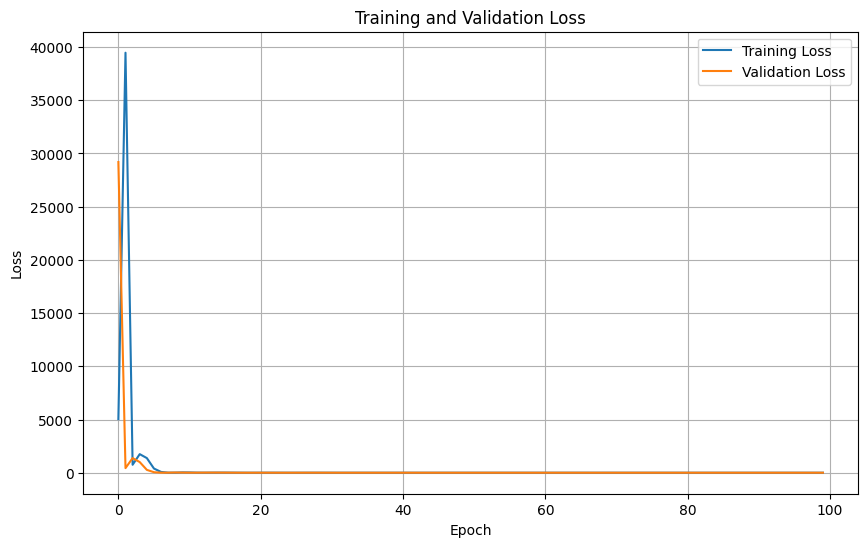

In [36]:
plot_loss(train_loss, valid_loss) # SAGE

In [37]:
final_evaluation(base_gnn_model, test_edge_index, test_edge_weights, user_features, product_features, best_model)

Test loss: 2.4436
Best possible loss: 2.4436


In [38]:
# SAGE GNN
GNNSAGE_model = GNNSAGERecommender(num_users, num_products, user_feature_dim, product_feature_dim)
optimizer = torch.optim.Adam(GNNSAGE_model.parameters(), lr=0.01)

In [39]:
train_loss, valid_loss, best_model = train_model(GNNSAGE_model, train_edge_index, train_edge_weights, val_edge_index, val_edge_weights, 
                                                 user_features, product_features, num_epochs = 100, print_progress=True)

Epoch: 10, Train Loss: 93.4513, Val Loss: 60.9855, best model epoch: 4
Epoch: 20, Train Loss: 15.5957, Val Loss: 14.9398, best model epoch: 12
Epoch: 30, Train Loss: 3.7108, Val Loss: 3.0424, best model epoch: 30
Epoch: 40, Train Loss: 2.8691, Val Loss: 2.3874, best model epoch: 40
Epoch: 50, Train Loss: 2.7254, Val Loss: 2.3096, best model epoch: 45
Epoch: 60, Train Loss: 2.5544, Val Loss: 2.2904, best model epoch: 55
Epoch: 70, Train Loss: 2.4582, Val Loss: 2.2416, best model epoch: 65
Epoch: 80, Train Loss: 2.3971, Val Loss: 2.2236, best model epoch: 74
Epoch: 90, Train Loss: 2.3413, Val Loss: 2.2091, best model epoch: 84
Epoch: 100, Train Loss: 2.2871, Val Loss: 2.1941, best model epoch: 100


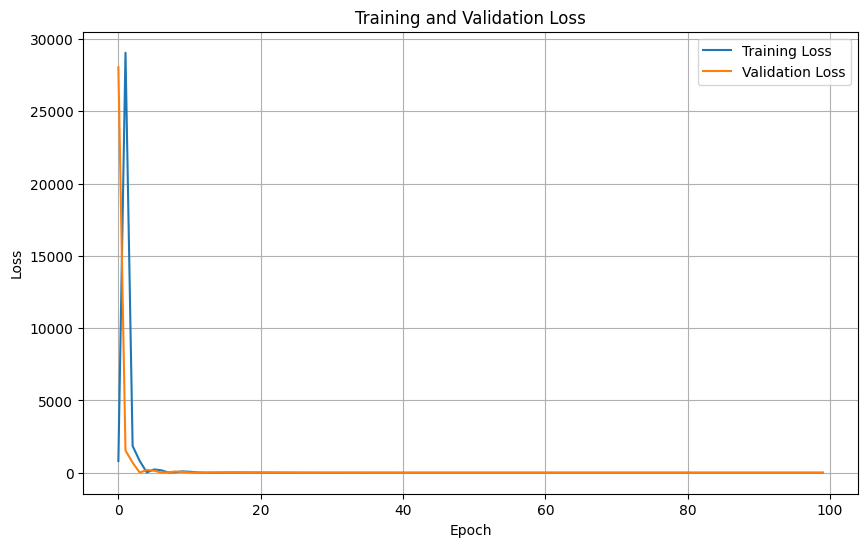

In [40]:
plot_loss(train_loss, valid_loss) # base GNNM

In [41]:
final_evaluation(GNNSAGE_model, test_edge_index, test_edge_weights, user_features, product_features, best_model)

Test loss: 2.2076
Best possible loss: 2.2076


# Next recomendations 

Based on the current set up, actually very trash cos the model predicts the exact same stuff (base GNN)  
GNNSAGE not say much better still alternates the same stuff

In [63]:
user_id = user_node_content_df.user_id.sample(1).item()
print(user_id, "\n")
recomendations = recommend_products(base_gnn_model, user_id, user_mapping, product_mapping,
                                     user_features, product_features, top_k=10)
pretty_print_recomendations(recomendations, product_title_df, "title")
print("\n")

recomendations = recommend_products(GNNSAGE_model, user_id, user_mapping, product_mapping,
                                     user_features, product_features, top_k=10)
pretty_print_recomendations(recomendations, product_title_df, "title")

AERXCYHIIAGXMHMHJBGJ3QASMPMA 

Product 1: Legends Collector Fiber-Optic LED Flashing Headband, 12 Headbands, Assorted Colors
Product 2: Almay Clear Complexion Pressed Powder, Hypoallergenic, Cruelty Free, Oil Free, Fragrance Free, Dermatologist Tested
Product 3: Advanced 5 Anti Aging Face Serum - Reduces the look of wrinkles, crow’s feet and forehead lines for a firmer, tighter and younger looking skin - Combines 5 very advanced elements with love and care from Mac and Mable.
Product 4: MOSTORY Glitter Crystal Liquid Eyeshadow Set - 4 Pack Pigmented Liquid Eye shadows Matte Shimmer Metallic Quick Dry Crease Resistant Long Lasting Flake-Proof Blendable Non-Greasy Eye Makeup (4 Pack)
Product 5: Nature's Gate Pomegranate Sunflower Lotion (Pack of 2) With Shea Butter, Sage Leaf Extract and Sunflower Seed Oil, 18 fl. oz. Each
Product 6: The Body Shop Shower Gel, Cranberry Joy, 8.45 Fluid Ounce
Product 7: Bath Accessories Ice Bag, Starfish
Product 8: 7 Colors Shiny Colored Eyeshadow Sticks, 

# DCG@10 testing 

This section is not from the colab notebook.  
Works to figure out the dcg@10 metric to compare against the paper  

From what i see, we need to be able to pass in some form of sequence into the prection.  
My current understanding is limited on how to tweak it to make it as such.  
Instead perhaps what we can do is to treat the test set as the ground truth label itself   
And then we do the same calcualtions  

In [253]:
user_idx = random.choice(test_edge_index[0]).item()
actual_prods = test_edge_index[1, test_edge_index[0] == user_idx]
paper_evaluation(base_gnn_model, user_idx, actual_prods, len(product_mapping), user_features, product_features, top_k=10)

(0.0, 0.0)